In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from scipy.stats import boxcox, kurtosis, skew
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/home/karvsmech/Projects/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.options.display.max_columns = 100
pd.options.display.max_rows =  200
pd.options.display.max_info_rows = 1690785
pd.options.display.max_info_columns = 200
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.date_dayfirst = True
pd.options.mode.chained_assignment = None    

/home/karvsmech/Projects/kaggle/input/house_prices_prediction/AmesHousing.csv
/home/karvsmech/Projects/kaggle/input/house_prices_prediction/data_description.txt
/home/karvsmech/Projects/kaggle/input/house_prices_prediction/top-1-w-leakage-ensemble-w-catboost.ipynb
/home/karvsmech/Projects/kaggle/input/house_prices_prediction/test.csv
/home/karvsmech/Projects/kaggle/input/house_prices_prediction/.~lock.train.csv#
/home/karvsmech/Projects/kaggle/input/house_prices_prediction/train.csv
/home/karvsmech/Projects/kaggle/input/house_prices_prediction/sample_submission.csv
/home/karvsmech/Projects/kaggle/input/heart_disease/heart_disease.csv


In [5]:
df = pd.read_csv('/home/karvsmech/Projects/kaggle/input/house_prices_prediction/train.csv')
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.00",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.00",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.00",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.00",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.00",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
dtypes = df.dtypes.to_frame().reset_index()
dtypes.columns = ['col', 'dtype']
dtypes.groupby('dtype').size()

dtype
int64      35
float64     3
object     43
dtype: int64

In [7]:
def na(df, percent=True, verbose=True):
    na_series = df.isna().sum()
    na_series = na_series.where(na_series > 0).dropna().sort_values(ascending=False)
    if percent:
        if verbose:
            print("% of NaNs in each column")
        return (na_series/df.shape[0]) * 100
    else:
        if verbose:
            print("# of NaNs in each column:")
        return na_series
    
na(df, True)

% of NaNs in each column


PoolQC         99.52
MiscFeature    96.30
Alley          93.77
Fence          80.75
MasVnrType     59.73
FireplaceQu    47.26
LotFrontage    17.74
GarageType      5.55
GarageYrBlt     5.55
GarageFinish    5.55
GarageQual      5.55
GarageCond      5.55
BsmtFinType2    2.60
BsmtExposure    2.60
BsmtFinType1    2.53
BsmtCond        2.53
BsmtQual        2.53
MasVnrArea      0.55
Electrical      0.07
dtype: float64

In [8]:
df.select_dtypes(exclude='O').corr(method='pearson')['GarageYrBlt'].sort_values(ascending=False)[:5]

GarageYrBlt    1.00
YearBuilt      0.83
YearRemodAdd   0.64
GarageCars     0.59
GarageArea     0.56
Name: GarageYrBlt, dtype: float64

In [9]:
df.select_dtypes(exclude='O').corr(method='kendall')['GarageYrBlt'].sort_values(ascending=False)[:5]

GarageYrBlt    1.00
YearBuilt      0.84
YearRemodAdd   0.64
GarageCars     0.52
OverallQual    0.47
Name: GarageYrBlt, dtype: float64

In [10]:
df.select_dtypes(exclude='O').corr(method='spearman')['GarageYrBlt'].sort_values(ascending=False)[:5]

GarageYrBlt    1.00
YearBuilt      0.89
YearRemodAdd   0.72
GarageCars     0.63
OverallQual    0.62
Name: GarageYrBlt, dtype: float64

<Axes: >

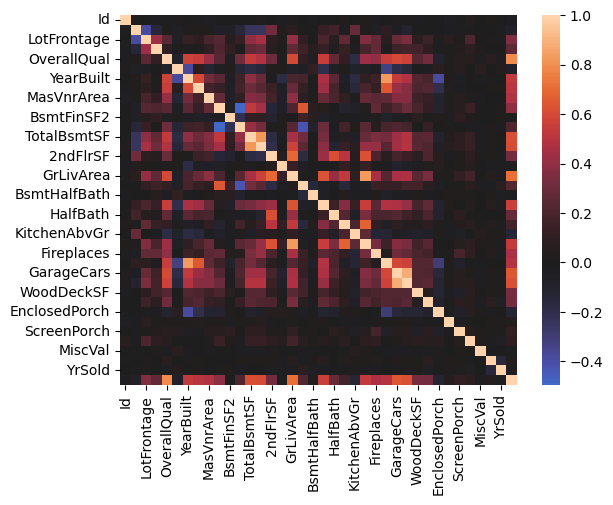

In [11]:
sns.heatmap(df.select_dtypes(exclude='O').corr(), center=0)

In [12]:
def get_corr_list(df, threshold = 0.6):
    num_vars = df.select_dtypes(include='number').columns.tolist()
    df_corr = df[num_vars].corr().unstack().to_frame().reset_index()
    df_corr.columns = ['var1', 'var2', 'corr']

    # removing rows where var1 is equal to var2
    df_corr = df_corr.loc[df_corr['var1'] != df_corr['var2'], :]
    df_corr['abs_corr'] = df_corr['corr'].abs()
    df_corr = df_corr.loc[df_corr['abs_corr'] > threshold, :]
    df_corr.sort_values(by=['abs_corr'], ascending=False, inplace=True)

    #remove mirrored items
    df_corr = df_corr.iloc[::2]
    
    return df_corr.reset_index()
    
    
df_corr = get_corr_list(df)
df_corr

,index,var1,var2,corr,abs_corr
0,1015,GarageCars,GarageArea,0.88,0.88
1,956,GarageYrBlt,YearBuilt,0.83,0.83
2,631,GrLivArea,TotRmsAbvGrd,0.83,0.83
3,469,TotalBsmtSF,1stFlrSF,0.82,0.82
4,189,OverallQual,SalePrice,0.79,0.79
5,645,GrLivArea,SalePrice,0.71,0.71
6,548,2ndFlrSF,GrLivArea,0.69,0.69
7,821,BedroomAbvGr,TotRmsAbvGrd,0.68,0.68
8,655,BsmtFullBath,BsmtFinSF1,0.65,0.65
9,957,GarageYrBlt,YearRemodAdd,0.64,0.64


In [13]:
# May be we need to use smoothing techniques, since many of the neighborhoods have really very few samples.

__neighborhood = df.groupby('Neighborhood').agg({'Neighborhood':'size', 'SalePrice':'mean'})
__neighborhood.sort_values('SalePrice')

,Neighborhood,SalePrice
Neighborhood,,
MeadowV,17,"98,576.47"
IDOTRR,37,"100,123.78"
BrDale,16,"104,493.75"
BrkSide,58,"124,834.05"
Edwards,100,"128,219.70"
OldTown,113,"128,225.30"
Sawyer,74,"136,793.14"
Blueste,2,"137,500.00"
SWISU,25,"142,591.36"


In [14]:
__condition1 = df.groupby('Condition1').agg({'Condition1':'size', 'SalePrice':'mean'})
__condition1.sort_values('SalePrice')

,Condition1,SalePrice
Condition1,,
Artery,48,"135,091.67"
RRAe,11,"138,400.00"
Feedr,81,"142,475.48"
RRAn,26,"184,396.62"
Norm,1260,"184,495.49"
RRNe,2,"190,750.00"
RRNn,5,"212,400.00"
PosN,19,"215,184.21"
PosA,8,"225,875.00"


In [15]:
__condition2 = df.groupby('Condition2').agg({'Condition2':'size', 'SalePrice':'mean'})
__condition2.sort_values('SalePrice')

,Condition2,SalePrice
Condition2,,
RRNn,2,"96,750.00"
Artery,2,"106,500.00"
Feedr,6,"121,166.67"
RRAn,1,"136,905.00"
Norm,1445,"181,169.41"
RRAe,1,"190,000.00"
PosN,2,"284,875.00"
PosA,1,"325,000.00"


In [16]:
__mssubclass = df.groupby('MSSubClass').agg({'MSSubClass':'size', 'SalePrice':'mean'})
__mssubclass.sort_values('SalePrice')

,MSSubClass,SalePrice
MSSubClass,,
30,69,"95,829.72"
180,10,"102,300.00"
45,12,"108,591.67"
190,30,"129,613.33"
90,52,"133,541.08"
160,63,"138,647.38"
50,144,"143,302.97"
85,20,"147,810.00"
40,4,"156,125.00"


In [17]:
__mszoning = df.groupby('MSZoning').agg({'MSZoning':'size', 'SalePrice':'mean'})
__mszoning.sort_values('SalePrice')

,MSZoning,SalePrice
MSZoning,,
C (all),10,"74,528.00"
RM,218,"126,316.83"
RH,16,"131,558.38"
RL,1151,"191,004.99"
FV,65,"214,014.06"


In [18]:
def feature_names(df):
    
    categorical_lst = df.select_dtypes('O').columns.to_list()
    
    print(f'the number of categorical features in the data are: {len(categorical_lst)}')
    
    numerical_lst = df.select_dtypes('number').columns.to_list()
    
    print(f'the number of numerical features in the data are: {len(numerical_lst)}')
    
    assert df.shape[1] == len(categorical_lst) + len(numerical_lst)
    
    return categorical_lst, numerical_lst


categorical_lst, numerical_lst = feature_names(df)

the number of categorical features in the data are: 43
the number of numerical features in the data are: 38


In [19]:
print(categorical_lst)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [20]:
# overallQual, OverallCond are true ordinals, and they stay as it is.
# they can be handled as numerical variable by the model.
print(numerical_lst)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [21]:
cat_cols = df.select_dtypes('O').columns.to_list() + ['MSSubClass']
cat_cols = [col for col in cat_cols if col not in ['Neighborhood', 'Condition1', 'Condition2', 'FireplaceQu']]
print(cat_cols)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass']


In [22]:
na(df[cat_cols])

% of NaNs in each column


PoolQC         99.52
MiscFeature    96.30
Alley          93.77
Fence          80.75
MasVnrType     59.73
GarageType      5.55
GarageFinish    5.55
GarageQual      5.55
GarageCond      5.55
BsmtExposure    2.60
BsmtFinType2    2.60
BsmtQual        2.53
BsmtCond        2.53
BsmtFinType1    2.53
Electrical      0.07
dtype: float64

In [23]:
# OneHotEncoder
ohencoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
ohencoder.set_output(transform='pandas')

# one hot encoder treats nan as a separate category.
df_cats_encoded = ohencoder.fit_transform(df[cat_cols])
df_cats_encoded

OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,Alley_nan,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,...,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.

In [24]:
df_cats_encoded.shape

(1460, 194)

In [25]:
df.shape

(1460, 81)

In [26]:
len(cat_cols)

40

In [27]:
# dropping all the categorical variable that has been "one hot encoded"
df = pd.concat([df.drop(cat_cols, axis=1), df_cats_encoded], axis=1)
df

,Id,LotFrontage,LotArea,Neighborhood,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,Alley_nan,LotShape_IR2,LotShape_IR3,...,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,1,65.00,8450,CollgCr,Norm,Norm,7,5,2003,2003,196.00,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,NaN,"2,003.00",2,548,0,61,0,0,0,0,0,2,2008,208500,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2,80.00,9600,Veenker,Feedr,Norm,6,8,1976,1976,0.00,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,TA,"1,976.00",2,460,298,0,0,0,0,0,0,5,2007,181500,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,3,68.00,11250,CollgCr,Norm,Norm,7,5,2001,2002,162.00,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,TA,"2,001.00",2,608,0,42,0,0,0,0,0,9,2008,223500,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,4,60.00,9550,Crawfor,Norm,Norm,7,5,1915,1970,0.00,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,Gd,"1,998.00",3,642,0,35,272,0,0,0,0,2,2006,140000,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,5,84.00,14260,NoRidge,Norm,Norm,8,5,2000,2000,350.00,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,TA,"2,000.00",3,836,192,84,0,0,0,0,0,12,2008,250000,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,62.00,7917,Gilbert,Norm,Norm,6,5,1999,2000,0.00,0,0,953,953

In [28]:
categorical_lst, numerical_lst = feature_names(df)

print('the categorical features are:')
print(categorical_lst)

print('\n\n')

print('the numerical features are:')
print(numerical_lst)

the number of categorical features in the data are: 4
the number of numerical features in the data are: 231
the categorical features are:
['Neighborhood', 'Condition1', 'Condition2', 'FireplaceQu']



the numerical features are:
['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave', 'Alley_Pave', 'Alley_nan', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_NoSeWa', 'LotConfig_CulDSac', 'LotConfig_FR2', 

In [29]:
# Handling missing values.
na(df, True)

% of NaNs in each column


FireplaceQu   47.26
LotFrontage   17.74
GarageYrBlt    5.55
MasVnrArea     0.55
dtype: float64

In [30]:
df['LotFrontage'] = df['LotFrontage'].fillna(0)
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

In [31]:
na(df, False)

# of NaNs in each column:


FireplaceQu   690.00
GarageYrBlt    81.00
dtype: float64

In [32]:
# there is a good coorelation between GarageYrBlt and YearBuilt. And since there are no missing values
# in YearBuilt, we can use the values from YearBuilt for the missing values of GarageYrBlt

df.select_dtypes(include='number').corr()['GarageYrBlt'].sort_values(ascending=False)

GarageYrBlt        1.00
YearBuilt          0.83
Foundation_PConc   0.66
YearRemodAdd       0.64
GarageCars         0.59
                   ... 
ExterCond_Po        NaN
GarageType_nan      NaN
GarageFinish_nan    NaN
GarageQual_nan      NaN
GarageCond_nan      NaN
Name: GarageYrBlt, Length: 231, dtype: float64

In [33]:
df.loc[df['GarageYrBlt'].isna(), 'GarageYrBlt'] = df.loc[df['GarageYrBlt'].isna(), 'YearBuilt']

In [34]:
na(df, False)

# of NaNs in each column:


FireplaceQu   690.00
dtype: float64

In [35]:
categorical_lst, numerical_lst = feature_names(df)

the number of categorical features in the data are: 4
the number of numerical features in the data are: 231


In [36]:
# Handling Outliers

df.select_dtypes(exclude='O').corr()['SalePrice'].sort_values(ascending=False)[:10]

SalePrice      1.00
OverallQual    0.79
GrLivArea      0.71
GarageCars     0.64
GarageArea     0.62
TotalBsmtSF    0.61
1stFlrSF       0.61
FullBath       0.56
TotRmsAbvGrd   0.53
YearBuilt      0.52
Name: SalePrice, dtype: float64

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

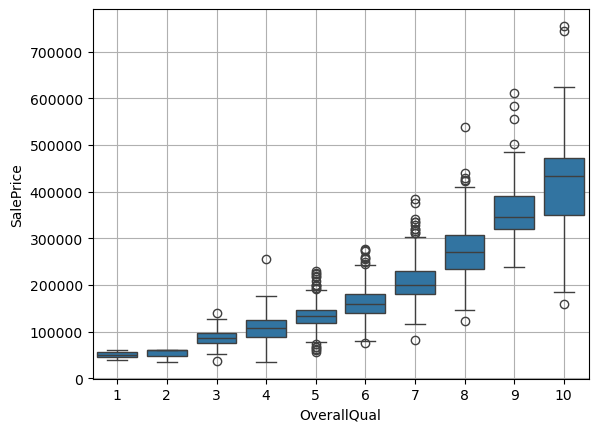

In [37]:
sns.boxplot(df, y='SalePrice', x='OverallQual')
plt.grid()

<Axes: xlabel='GarageCars', ylabel='SalePrice'>

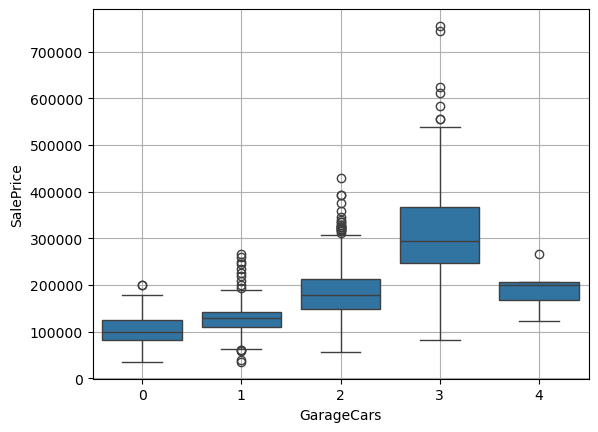

In [38]:
sns.boxplot(df, y='SalePrice', x='GarageCars')
plt.grid()

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

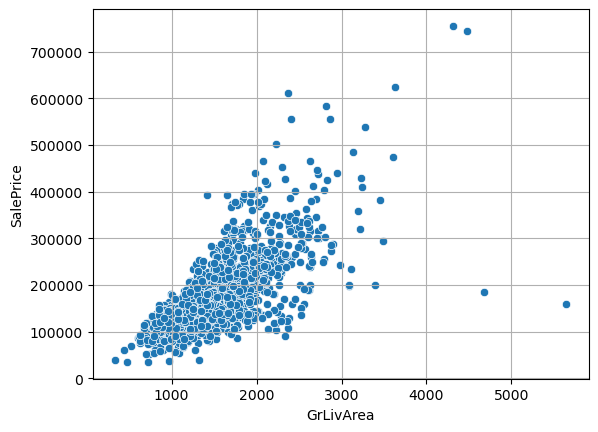

In [39]:
sns.scatterplot(df, y='SalePrice', x='GrLivArea')
plt.grid()

<Axes: xlabel='OverallCond', ylabel='SalePrice'>

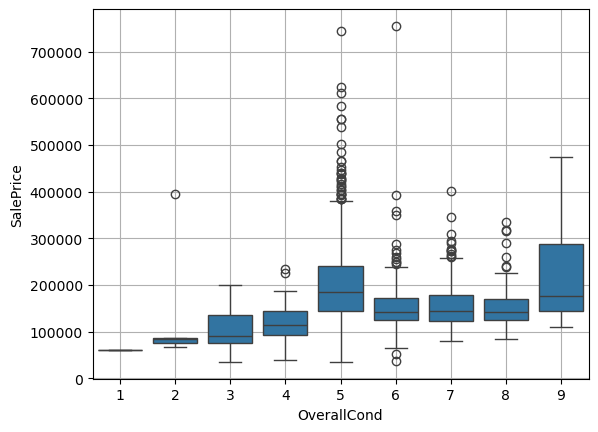

In [40]:
sns.boxplot(df, y='SalePrice', x='OverallCond')
plt.grid()

In [41]:
# all outliers

outliers = pd.concat([
    df[(df['OverallQual'] == 4) & (df['SalePrice'] > 2e5)],
    df[(df['OverallQual'] == 8) & (df['SalePrice'] > 5e5)],
    df[(df['OverallQual'] == 10) & (df['SalePrice'] > 7e5)],
    df[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 3e5)],
    df[(df['OverallCond'] == 2) & (df['SalePrice'] > 3e5)],
    df[(df['OverallCond'] == 6) & (df['SalePrice'] > 7e5)]
    ]).sort_index().drop_duplicates()

outliers

,Id,LotFrontage,LotArea,Neighborhood,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,Alley_nan,LotShape_IR2,LotShape_IR3,...,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
378,379,88.00,11394,StoneBr,Norm,Norm,9,2,2010,2010,350.00,1445,0,411,1856,1856,0,0,1856,1,0,1,1,1,1,8,1,Ex,"2,010.00",3,834,113,0,0,0,0,0,0,6,2010,394432,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
457,458,0.00,53227,ClearCr,Norm,Norm,4,6,1954,1994,0.00,1116,0,248,1364,1663,0,0,1663,1,0,1,0,2,1,6,2,Gd,"1,954.00",2,529,224,137,0,0,0,0,0,3,2008,256000,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
523,524,130.00,40094,Edwards,PosN,PosN,10,5,2007,2008,762.00,2260,0,878,3138,3138,1538,0,4676,1,0,3,1,3,1,11,1,Gd,"2,007.00",3,884,208,406,0,0,0,0,0,10,2007,184750,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
691,692,104.00,21535,NoRidge,Norm,Norm,10,6,1994,1995,"1,170.00",1455,0,989,2444,2444,1872,0,4316,0,1,3,1,4,1,10,2,Ex,"1,994.00",3,832,382,50,0,0,0,0,0,1,2007,755000,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
769,770,47.00,53504,StoneBr,Norm,Norm,8,5,2003,2003,603.00,1416,0,234,1650,1690,1589,0,3279,1,0,3,1,4,1,12,1,Gd,"2,003.00",3,841,503,36,0,0,210,0,0,6,2010,538000,0.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1182,1183,160.00,15623,NoRidge,Norm,Norm,10,5,1996,1996,0.00,2096,0,300,2396,2411,2065,0,4476,1,0,3,1,4,1,10,2,TA,"1,996.00",3,813,171,78,0,0,0,555,0,7,2007,745000,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.

In [42]:
df = df.drop(outliers.index)
df.shape

(1453, 235)

In [43]:
na(df, False)

# of NaNs in each column:


FireplaceQu   690.00
dtype: float64

In [44]:
df_temp_numerical = df.select_dtypes(include='number')
df_temp = df_temp_numerical<0
_ser = df_temp.sum(axis=1)
# no negative values are there, and we can
# do both log transformation or boxcox.
_ser.where(_ser > 0).dropna()

Series([], dtype: float64)

In [45]:
# Power transformation - skew, kurtosis, Box Cox

skew_kurtosis_data = []
for col in df.select_dtypes(include='number').columns:
    srs = df[col].dropna()
    ln_srs = np.log1p(srs)
    skew_kurtosis_data.append({
        'name':col,
        'normal_skew':skew(srs),
        'ln_skew':skew(ln_srs),
        'normal_kurtosis':kurtosis(srs),
        'ln_kurtosis':kurtosis(ln_srs)
    })

skew_kurtosis_data

[{'name': 'Id',
  'normal_skew': -0.0009322173984965627,
  'ln_skew': -1.7884424511033952,
  'normal_kurtosis': -1.2016000461574077,
  'ln_kurtosis': 4.026652357203108},
 {'name': 'LotFrontage',
  'normal_skew': -0.0049672288777894025,
  'ln_skew': -1.554368654274307,
  'normal_kurtosis': 1.9619351014490416,
  'ln_kurtosis': 0.6176052188984049},
 {'name': 'LotArea',
  'normal_skew': 12.970147233575807,
  'ln_skew': -0.227771700755456,
  'normal_kurtosis': 224.12683141729357,
  'ln_kurtosis': 4.7942543700523395},
 {'name': 'OverallQual',
  'normal_skew': 0.18321681349066565,
  'ln_skew': -0.6197486578662844,
  'normal_kurtosis': 0.05846244379796728,
  'ln_kurtosis': 2.091651333784248},
 {'name': 'OverallCond',
  'normal_skew': 0.7130047149962517,
  'ln_skew': -0.20325435182131185,
  'normal_kurtosis': 1.0619809801182463,
  'ln_kurtosis': 3.121712543874297},
 {'name': 'YearBuilt',
  'normal_skew': -0.6092585819961439,
  'ln_skew': -0.6369324859809405,
  'normal_kurtosis': -0.444938191416

In [46]:
skew_kurtosis_data = pd.DataFrame(skew_kurtosis_data)
skew_kurtosis_data.iloc[:, 1:] = skew_kurtosis_data.iloc[:, 1:].abs()
skew_kurtosis_data

,name,normal_skew,ln_skew,normal_kurtosis,ln_kurtosis
0,Id,0.00,1.79,1.20,4.03
1,LotFrontage,0.00,1.55,1.96,0.62
2,LotArea,12.97,0.23,224.13,4.79
3,OverallQual,0.18,0.62,0.06,2.09
4,OverallCond,0.71,0.20,1.06,3.12
...,...,...,...,...,...
226,MSSubClass_90,5.00,5.00,22.98,22.98
227,MSSubClass_120,3.71,3.71,11.76,11.76
228,MSSubClass_160,4.48,4.48,18.11,18.11
229,MSSubClass_180,11.93,11.93,140.31,140.31


In [47]:
skew_kurtosis_data.to_csv('../output/house_prices_prediction/skewness.csv', index=False, index_label=False)

In [48]:
# boxcox_lambdas = []
# df_numeric = df.select_dtypes(include='number')
# for col in df_numeric.columns:
#     _, best_lambda = boxcox(df_numeric[col] + 1)
#     boxcox_lambdas.append({'name': col,
#                           'boxcox_lambda': best_lambda})
    
# df_boxcox = pd.DataFrame(boxcox_lambdas).set_index('name')
# df_boxcox

In [49]:
# df_temp = df_boxcox.loc[df_numeric.nunique() > 100, :]
# df_temp

In [50]:
# for col in df_temp.index:
#     fig, ax = plt.subplots(1, 2, figsize=(12, 6))
#     sns.histplot(df_numeric[col], kde=True, ax=ax[0], bins=50)
#     ax[0].title.set_text('no transformation')
    
#     best_lambda = df_temp.loc[col].values[0]
#     boxcox_transformed_data = boxcox(df_numeric[col]+1, best_lambda)
#     sns.histplot(boxcox_transformed_data, kde=True, ax=ax[1], bins=50)
#     ax[1].title.set_text(f'with transformation, a={best_lambda:.2f}')
    
#     fig.suptitle(col)
#     plt.show()

In [51]:
boxcox_lambdas = []
for col in df.select_dtypes(exclude='O').columns:
    # only positive values can be sent into boxcox
    coef = boxcox(df[col] + 1)[1]
    boxcox_lambdas.append({'name':col,
                          'boxcox_coef':coef})
boxcox_lambdas = pd.DataFrame(boxcox_lambdas).set_index('name')

In [52]:
uniques = df.nunique()
boxcox_lambdas.loc[uniques.loc[uniques >= 100].index]

,boxcox_coef
Id,0.71
LotFrontage,0.76
LotArea,0.05
YearBuilt,21.96
MasVnrArea,-0.25
BsmtFinSF1,0.23
BsmtFinSF2,-1.51
BsmtUnfSF,0.47
TotalBsmtSF,0.81
1stFlrSF,0.00


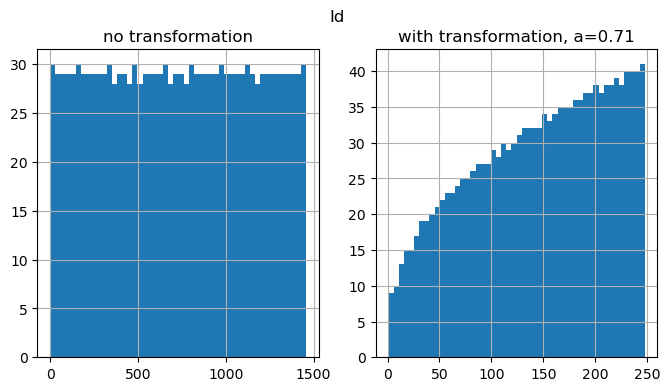

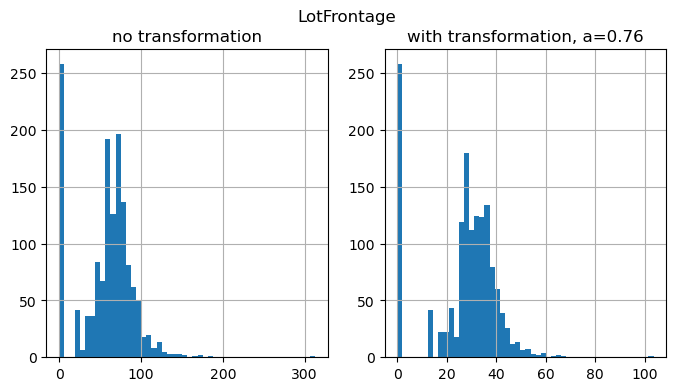

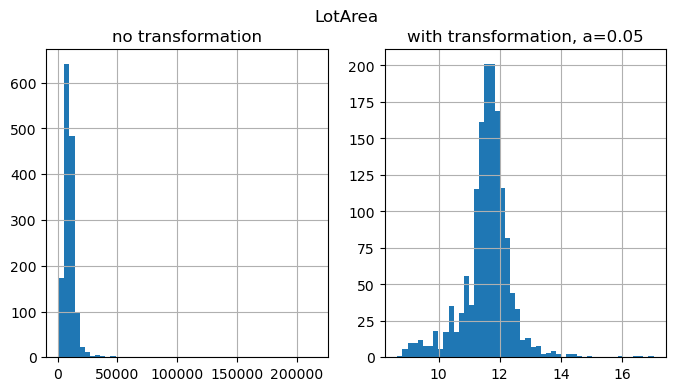

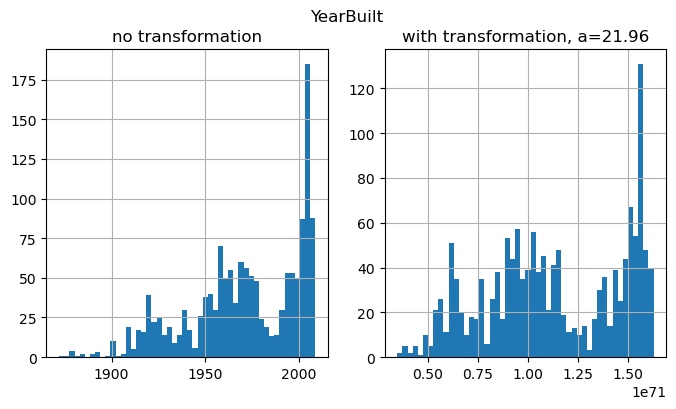

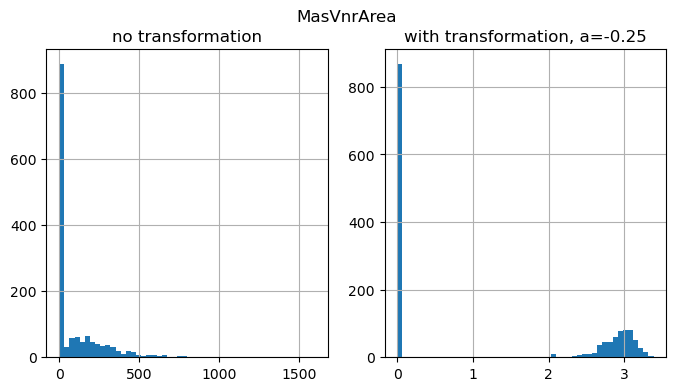

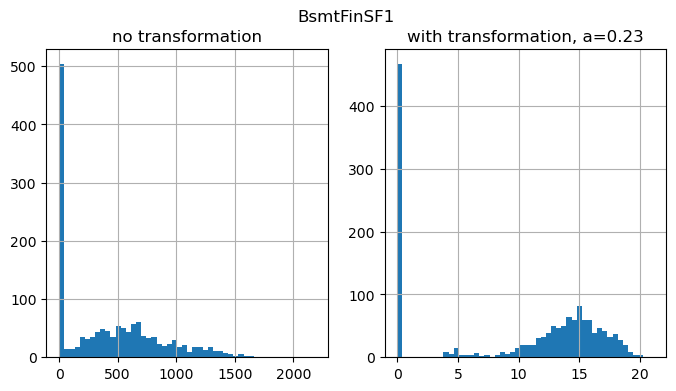

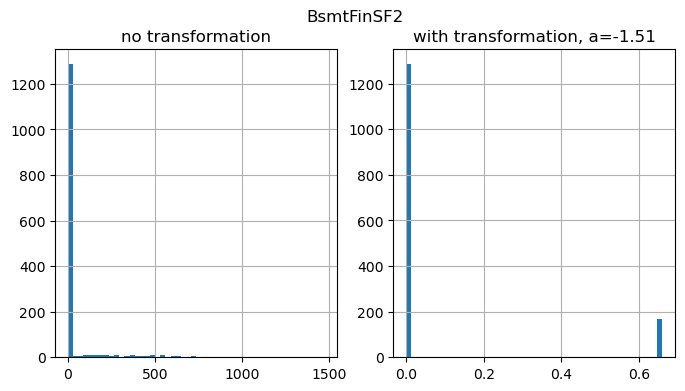

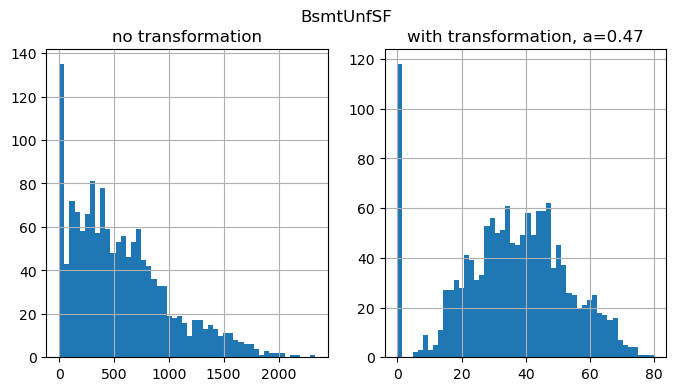

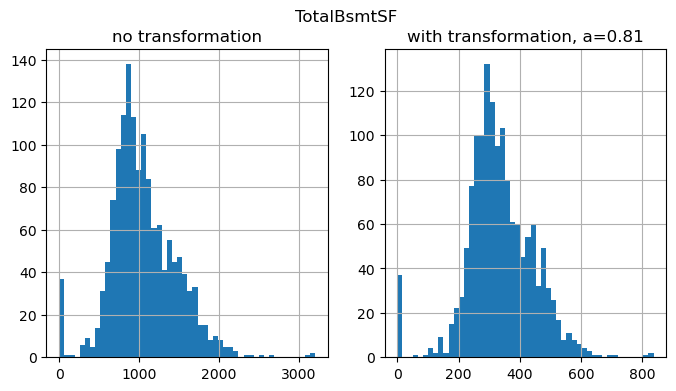

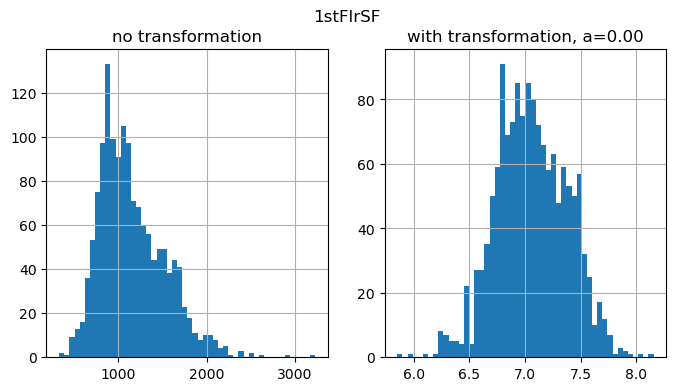

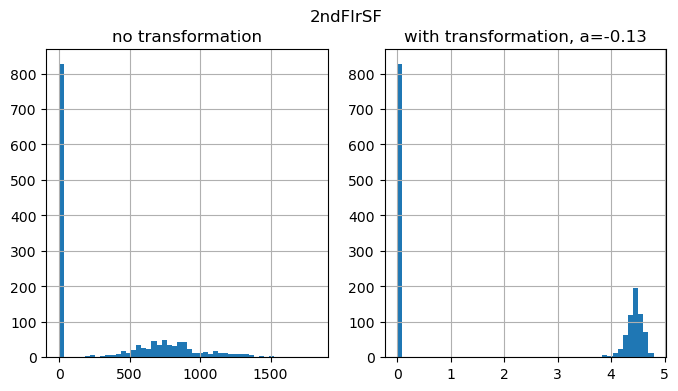

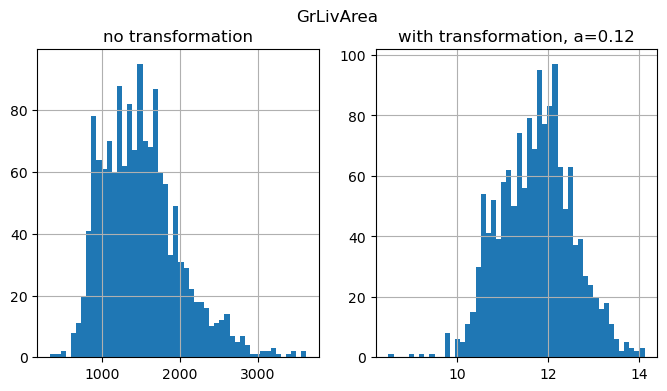

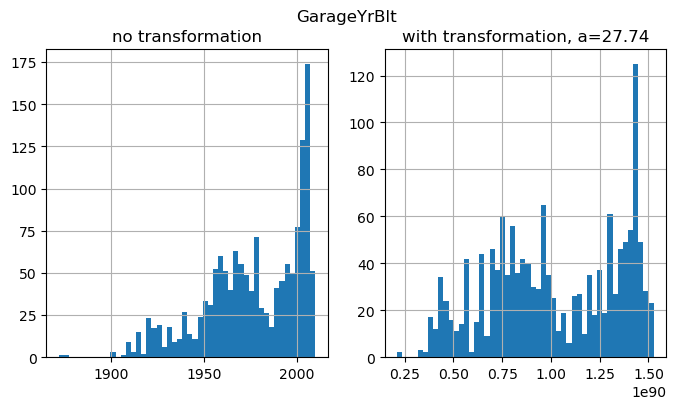

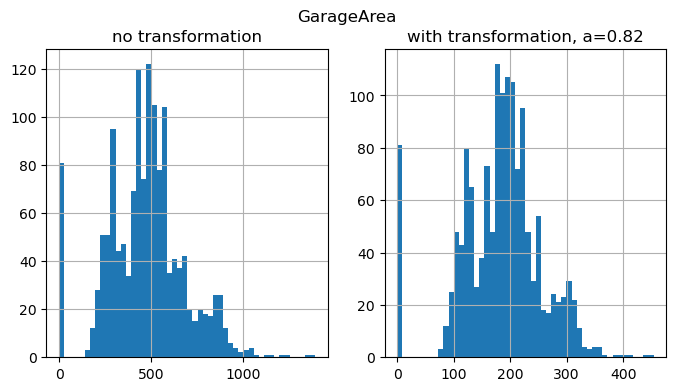

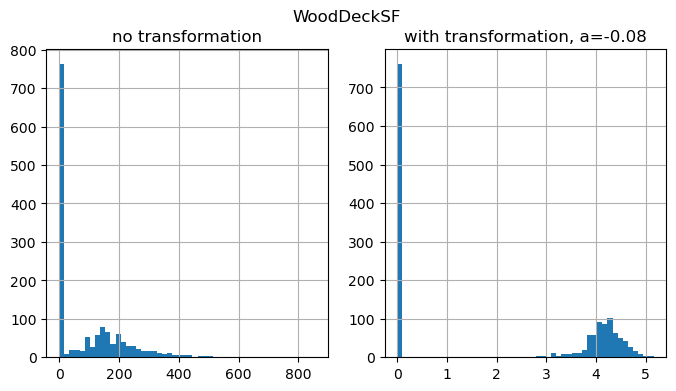

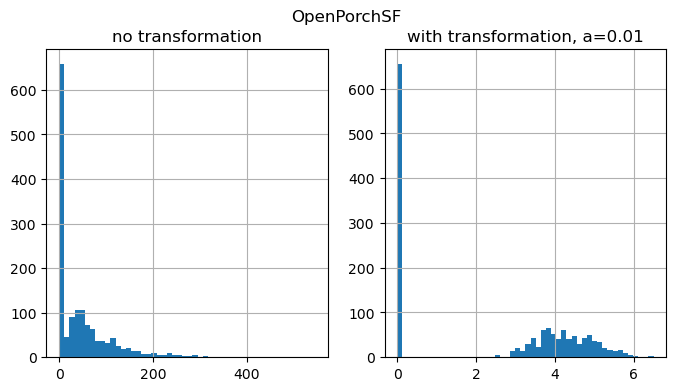

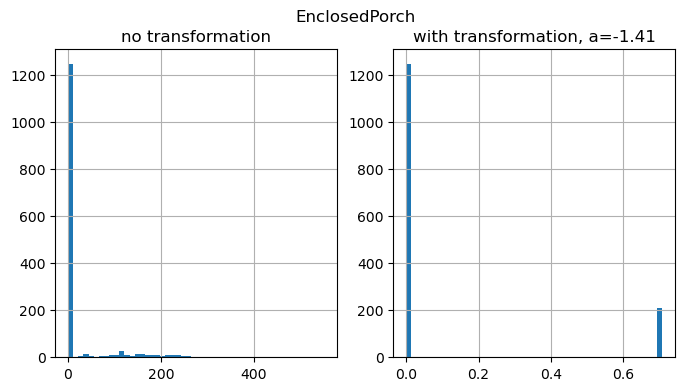

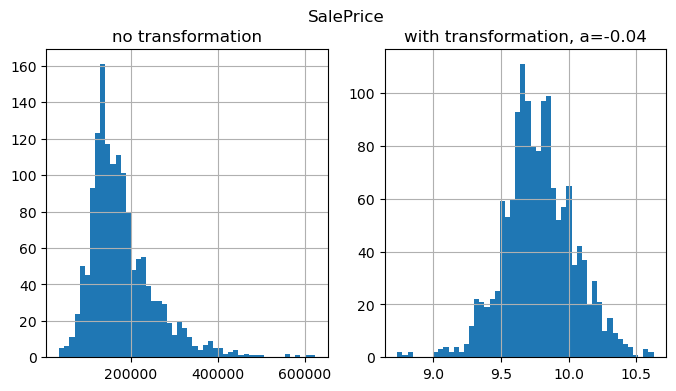

In [53]:
def lambda_comparison(col):
    
    figs, axes = plt.subplots(1, 2, figsize=(8, 4))
    df[col].hist(bins=50, ax=axes[0])
    axes[0].title.set_text('no transformation')
    
    _lambda = boxcox_lambdas.loc[col].values[0]
    pd.Series(boxcox(df[col] + 1, _lambda)).hist(bins=50, ax=axes[1])
    axes[1].title.set_text(f'with transformation, a={_lambda:.2f}')
    figs.suptitle(col)
    plt.show()
    return None

for col in boxcox_lambdas.loc[uniques.loc[uniques >= 100].index].index:
    lambda_comparison(col)

In [54]:
df['LotArea'].describe()

count     1,453.00
mean     10,389.06
std       9,741.37
min       1,300.00
25%       7,535.00
50%       9,453.00
75%      11,553.00
max     215,245.00
Name: LotArea, dtype: float64

In [55]:
decided_lambdas_dict = {
    'LotArea':0, 'MasVnrArea':0, 
    'BsmtFinSF1':0, 'BsmtUnfSF':.5, 
    '1stFlrSF':0, 'GrLivArea':0, 
    'WoodDeckSF':0, 'OpenPorchSF':0, 
    'SalePrice':0
}

for col, lmbda in decided_lambdas_dict.items():
    df[col] = boxcox(df[col] + 1, lmbda)

df['LotArea'].describe()

count   1,453.00
mean        9.11
std         0.51
min         7.17
25%         8.93
50%         9.15
75%         9.35
max        12.28
Name: LotArea, dtype: float64

In [56]:
na(df, False)

# of NaNs in each column:


FireplaceQu   690.00
dtype: float64

In [57]:
df.select_dtypes('O').columns.tolist()

['Neighborhood', 'Condition1', 'Condition2', 'FireplaceQu']

In [58]:
print(df.select_dtypes('number').columns.tolist())

['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave', 'Alley_Pave', 'Alley_nan', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_NoSeWa', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Mod', 'LandSlope_Sev', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf',

In [59]:
# Feature engineering

In [60]:
dt_df = pd.to_datetime(df['MoSold'].astype('str') + '.' + df['YrSold'].astype('str'), 
                       format="%m.%Y").rename('date')
dt_df = pd.concat([dt_df, df['SalePrice']], axis=1).set_index('date')

In [61]:
average_price_at_date = dt_df.groupby(pd.Grouper(freq='MS'))['SalePrice'].mean().to_frame().reset_index().rename({
    'SalePrice':'average_price_at_date'}, axis=1)
average_price_at_date['date'] = average_price_at_date['date'].dt.strftime('%m.%Y')
average_price_at_date

,date,average_price_at_date
0,01.2006,12.14
1,02.2006,12.16
2,03.2006,12.05
3,04.2006,11.98
4,05.2006,11.93
5,06.2006,11.97
6,07.2006,12.04
7,08.2006,12.11
8,09.2006,12.22
9,10.2006,11.96


<Axes: xlabel='date'>

<Axes: xlabel='date'>

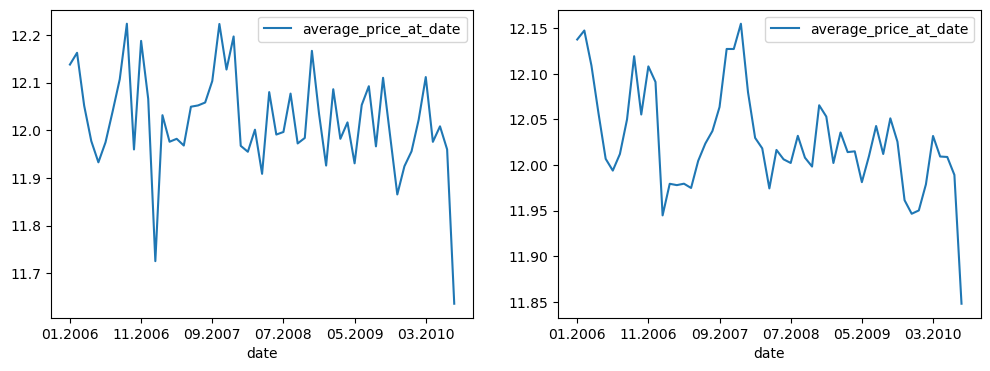

In [62]:
figs, axes = plt.subplots(1, 2, figsize=(12, 4))
average_price_at_date.plot(x='date', y='average_price_at_date', ax=axes[0])

average_price_at_date_smoothed = pd.concat([average_price_at_date['date'], 
                                   average_price_at_date['average_price_at_date'].ewm(span=4, adjust=False).mean()],
                                          axis=1)
average_price_at_date_smoothed.plot(x='date', y='average_price_at_date', ax=axes[1])
plt.show()

In [63]:
# average price at time
df['date'] = pd.to_datetime(df['MoSold'].astype('str') + '.' + df['YrSold'].astype('str'), 
                       format="%m.%Y").dt.strftime('%m.%Y')
df = df.merge(average_price_at_date_smoothed, on =['date'], how='left')
df.drop('date', axis=1, inplace=True)
df

,Id,LotFrontage,LotArea,Neighborhood,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,Alley_nan,LotShape_IR2,LotShape_IR3,...,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,average_price_at_date
0,1,65.00,9.04,CollgCr,Norm,Norm,7,5,2003,2003,5.28,6.56,0,22.58,856,6.75,854,0,7.44,1,0,2,1,3,1,8,0,NaN,"2,003.00",2,548,0.00,4.13,0,0,0,0,0,2,2008,12.25,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.03
1,2,80.00,9.17,Veenker,Feedr,Norm,6,8,1976,1976,0.00,6.89,0,31.76,1262,7.14,0,0,7.14,0,1,2,0,3,1,6,1,TA,"1,976.00",2,460,5.70,0.00,0,0,0,0,0,5,2007,12.11,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.97
2,3,68.00,9.33,CollgCr,Norm,Norm,7,5,2001,2002,5.09,6.19,0,39.71,920,6.83,866,0,7.49,1,0,2,1,3,1,6,1,TA,"2,001.00",2,608,0.00,3.76,0,0,0,0,0,9,2008,12.32,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.01
3,4,60.00,9.16,Crawfor,Norm,Norm,7,5,1915,1970,0.00,5.38,0,44.52,756,6.87,756,0,7.45,1,0,1,0,3,1,7,1,Gd,"1,998.00",3,642,0.00,3.58,272,0,0,0,0,2,2006,11.85,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.15
4,5,84.00,9.57,NoRidge,Norm,Norm,8,5,2000,2000,5.86,6.49,0,42.32,1145,7.04,1053,0,7.70,1,0,2,1,4,1,9,1,TA,"2,000.00",3,836,5.26,4.44,0,0,0,0,0,12,2008,12.43,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,1456,62.00,8.98,Gilbert,

In [64]:
# average price at Neighborhood
avg_price_at_neighborhood = df.groupby('Neighborhood', as_index=False)['SalePrice'].mean().rename({'SalePrice':
                                                                        'avg_price_at_neighborhood'}, axis=1)
df = df.merge(avg_price_at_neighborhood, on =['Neighborhood'], how='left')
df.drop('Neighborhood', axis=1, inplace=True)
df

,Id,LotFrontage,LotArea,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,Alley_nan,LotShape_IR2,LotShape_IR3,LotShape_Reg,...,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,average_price_at_date,avg_price_at_neighborhood
0,1,65.00,9.04,Norm,Norm,7,5,2003,2003,5.28,6.56,0,22.58,856,6.75,854,0,7.44,1,0,2,1,3,1,8,0,NaN,"2,003.00",2,548,0.00,4.13,0,0,0,0,0,2,2008,12.25,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.03,12.16
1,2,80.00,9.17,Feedr,Norm,6,8,1976,1976,0.00,6.89,0,31.76,1262,7.14,0,0,7.14,0,1,2,0,3,1,6,1,TA,"1,976.00",2,460,5.70,0.00,0,0,0,0,0,5,2007,12.11,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.97,12.34
2,3,68.00,9.33,Norm,Norm,7,5,2001,2002,5.09,6.19,0,39.71,920,6.83,866,0,7.49,1,0,2,1,3,1,6,1,TA,"2,001.00",2,608,0.00,3.76,0,0,0,0,0,9,2008,12.32,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.01,12.16
3,4,60.00,9.16,Norm,Norm,7,5,1915,1970,0.00,5.38,0,44.52,756,6.87,756,0,7.45,1,0,1,0,3,1,7,1,Gd,"1,998.00",3,642,0.00,3.58,272,0,0,0,0,2,2006,11.85,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.15,12.21
4,5,84.00,9.57,Norm,Norm,8,5,2000,2000,5.86,6.49,0,42.32,1145,7.04,1053,0,7.70,1,0,2,1,4,1,9,1,TA,"2,000.00",3,836,5.26,4.44,0,0,0,0,0,12,2008,12.43,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.05,12.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,1456,62.00,8.98,Norm,N

In [65]:
conditions = list(set(df['Condition1'].unique().tolist() + df['Condition2'].unique().tolist()))
conditions.remove('Norm')
conditions

['RRNn', 'RRNe', 'RRAe', 'RRAn', 'Artery', 'PosA', 'Feedr', 'PosN']

In [66]:
for condition in conditions:
    df[f'Condition_{condition}'] = ((df['Condition1'] == condition) | (df['Condition2'] == condition)).astype('int')
df = df.drop(['Condition1', 'Condition2'], axis=1)
df

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,Alley_nan,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,average_price_at_date,avg_price_at_neighborhood,Condition_RRNn,Condition_RRNe,Condition_RRAe,Condition_RRAn,Condition_Artery,Condition_PosA,Condition_Feedr,Condition_PosN
0,1,65.00,9.04,7,5,2003,2003,5.28,6.56,0,22.58,856,6.75,854,0,7.44,1,0,2,1,3,1,8,0,NaN,"2,003.00",2,548,0.00,4.13,0,0,0,0,0,2,2008,12.25,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.03,12.16,0,0,0,0,0,0,0,0
1,2,80.00,9.17,6,8,1976,1976,0.00,6.89,0,31.76,1262,7.14,0,0,7.14,0,1,2,0,3,1,6,1,TA,"1,976.00",2,460,5.70,0.00,0,0,0,0,0,5,2007,12.11,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.97,12.34,0,0,0,0,0,0,1,0
2,3,68.00,9.33,7,5,2001,2002,5.09,6.19,0,39.71,920,6.83,866,0,7.49,1,0,2,1,3,1,6,1,TA,"2,001.00",2,608,0.00,3.76,0,0,0,0,0,9,2008,12.32,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.01,12.16,0,0,0,0,0,0,0,0
3,4,60.00,9.16,7,5,1915,1970,0.00,5.38,0,44.52,756,6.87,756,0,7.45,1,0,1,0,3,1,7,1,Gd,"1,998.00",3,642,0.00,3.58,272,0,0,0,0,2,2006,11.85,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.15,12.21,0,0,0,0,0,0,0,0
4,5,84.00,9.57,8,5,2000,2000,5.86,6.49,0,42.32,1145,7.04,1053,0,7.70,1,0,2,1,4,1,9,1,TA,"2,000.00",3,836,5.26,4.44,0,0,0,0,0,12,2008,12.43,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.05,12.63,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,1456,62.00,8.98,6,5,1999,2000,0.00,0.00,0,59.77,953,6.86,694,0,7.41,0,0,2,1,3,1,7,1,TA,"1,999.00",2,460,0.00,3.71,0,0,0,0,0,

In [67]:
df.to_csv('../output/house_prices_prediction/before_processing.csv', index=False, index_label=False)

In [50]:
# data processing pipeline

def process_data(df: pd.DataFrame, return_saleprice: bool = True, mode: str = 'train') -> pd.DataFrame:
    
    """
    process data
    """
    
    # one hot encoding (OHE)
    # one hot encoder treats nan as a separate category.
    df_cats_encoded = ohencoder.fit_transform(df[cat_cols])
    df = pd.concat([df.drop(cat_cols, axis=1), df_cats_encoded], axis=1)
    
    # handling outliers in the training data
    if mode == 'train':
        df = df.drop(outliers.index)
        
    # boxcox transformation
    for col, lmbda in decided_lambdas_dict.items():
        if mode == test and col == 'SalePrice':
            continue
        else:
            df[col] = boxcox(df[col] + 1, lmbda)
            
    # feature engineering
    df['date'] = pd.to_datetime(df['MoSold'].astype('str') + '.' + df['YrSold'].astype('str'), format='%m.%Y').dt.strftime('%m.%Y')
    df = df.merge(avg_price_at_date_smoothed, how='left', on='date')
    df = df.drop('date', axis=1)
    
    df = df.merge(avg_price_at_neighborhood, how='left', on='Neighborhood')
    df = df.drop('Neighborhood', axis=1)

    for condition in conditions:
        df[f'Condition_{condition}'] = ((df['Condition1'] == condition) | (df['Condition2'] == condition)).astype('int')
    df = df.drop(['Condition1', 'Condition2'], axis=1)
    
    
    

In [47]:
df = pd.read_csv('/home/karvsmech/Projects/kaggle/input/house_prices_prediction/train.csv')
# AmesHousing is a similar data available on kaggle. this way we increase the data available for model training 
df1 = pd.read_csv('/home/karvsmech/Projects/kaggle/input/house_prices_prediction/AmesHousing.csv').drop('PID', axis=1)
df = pd.concat([df, df1], axis=0)
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,...,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
0,1.00,60.00,RL,65.00,"8,450.00",Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.00,5.00,"2,003.00","2,003.00",Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706.00,Unf,0.00,150.00,856.00,GasA,Ex,Y,SBrkr,856.00,854.00,0.00,"1,710.00",1.00,0.00,2.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.00,20.00,RL,80.00,"9,600.00",Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.00,8.00,"1,976.00","1,976.00",Gable,CompShg,MetalSd,MetalSd,NaN,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.00,Unf,0.00,284.00,"1,262.00",GasA,Ex,Y,SBrkr,"1,262.00",0.00,0.00,"1,262.00",0.00,1.00,2.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.00,60.00,RL,68.00,"11,250.00",Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.00,5.00,"2,001.00","2,002.00",Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.00,Unf,0.00,434.00,920.00,GasA,Ex,Y,SBrkr,920.00,866.00,0.00,"1,786.00",1.00,0.00,2.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.00,70.00,RL,60.00,"9,550.00",Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.00,5.00,"1,915.00","1,970.00",Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216.00,Unf,0.00,540.00,756.00,GasA,Gd,Y,SBrkr,961.00,756.00,0.00,"1,717.00",1.00,0.00,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.00,60.00,RL,84.00,"14,260.00",Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.00,5.00,"2,000.00","2,000.00",Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655.00,Unf,0.00,490.00,"1,145.00",GasA,Ex,Y,SBrkr,"1,145.00","1,053.00",0.00,"2,198.00",1.00,0.00,2.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [51]:
process_data(df)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass']
